In [1]:
from math import ceil #importanto função ceil

#  Av1 Modelagem parametrica e Simulações digitais
# equipe: Luiza e Victor
# aluna 1: Luiza Seabra Batista Henriques Ramos
# aluno 2: Victor Santos da Silva


!pip install geopandas contextily shapely mapclassify


In [2]:
from google.colab import files
uploaded = files.upload()


ModuleNotFoundError: No module named 'google'

In [ ]:
df_geo.columns


Index(['CD_SETOR', 'AREA_KM2', 'CD_REGIAO', 'NM_REGIAO', 'CD_UF', 'NM_UF',
       'CD_MUN', 'NM_MUN', 'CD_DIST', 'NM_DIST', 'CD_SUBDIST', 'NM_SUBDIST',
       'CD_MICRO', 'NM_MICRO', 'CD_MESO', 'NM_MESO', 'CD_RGI', 'NM_RGI',
       'CD_RGINT', 'NM_RGINT', 'CD_CONCURB', 'NM_CONCURB', 'v0001', 'v0002',
       'v0003', 'v0004', 'v0005', 'v0006', 'v0007', 'geometry'],
      dtype='object')

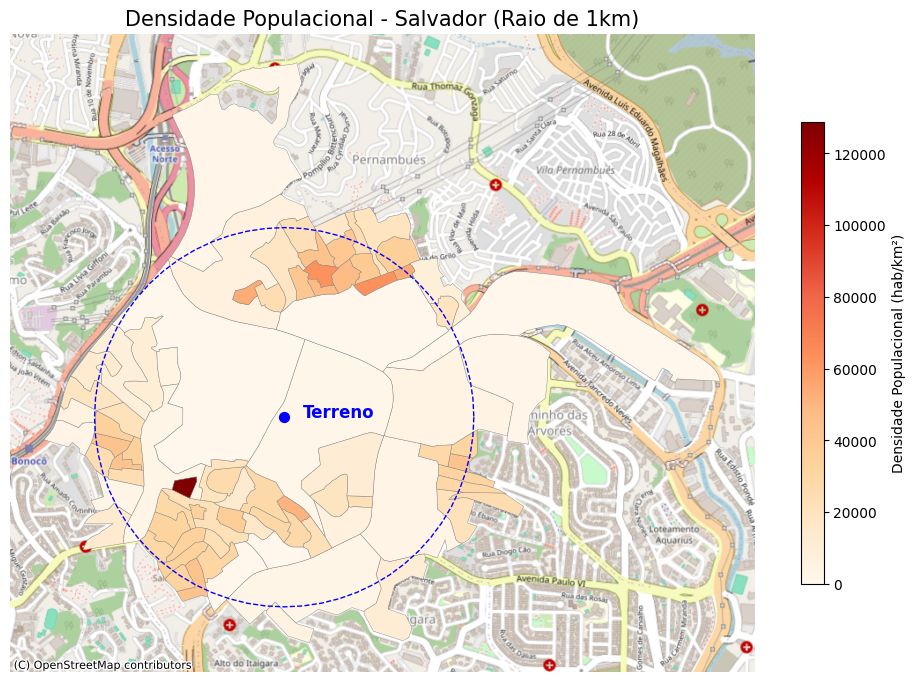

In [ ]:
# 📦 Importando bibliotecas
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import contextily as ctx
from google.colab import files

# 🌍 Lê o arquivo como GeoDataFrame
df_geo = gpd.read_file(filename)

# 🏙️ Filtra somente setores de Salvador
salvador = df_geo[df_geo["NM_MUN"] == "Salvador"].copy()

# 🔁 Reprojeta para o sistema de coordenadas EPSG:31984 (UTM zona 24S)
salvador = salvador.to_crs(epsg=31984)

# 🔢 Converte população para número (coluna v0001 = população total)
salvador["v0001"] = pd.to_numeric(salvador["v0001"], errors="coerce")

# 🧮 Calcula a densidade populacional (hab/km²)
salvador["densidade"] = salvador["v0001"] / (salvador.geometry.area / 1e6)

# 📍 Define um ponto em Salvador (ex: Shopping da Bahia)
longitude = -38.4712
latitude = -12.9822
ponto_wgs84 = Point(longitude, latitude)
ponto_gdf = gpd.GeoDataFrame([{"geometry": ponto_wgs84}], crs="EPSG:4326")

# 🔄 Reprojeta o ponto para o mesmo CRS da malha
ponto_gdf = ponto_gdf.to_crs(epsg=31984)
ponto_proj = ponto_gdf.geometry.iloc[0]

# 📏 Cria buffer de 1km ao redor do ponto
buffer_1km = ponto_proj.buffer(1000)

# 🔍 Filtra setores dentro do buffer
salvador_buffer = salvador[salvador.intersects(buffer_1km)]

# 🗺️ Gera o mapa final
fig, ax = plt.subplots(figsize=(12, 10))

# 🟠 Plota setores com cores pela densidade
salvador_buffer.plot(
    column="densidade",
    cmap="OrRd",
    linewidth=0.3,
    edgecolor="gray",
    legend=True,
    ax=ax,
    legend_kwds={'label': "Densidade Populacional (hab/km²)", 'shrink': 0.6}
)

# 🔵 Plota o ponto central
ponto_gdf.plot(ax=ax, color="blue", markersize=50, zorder=5)

# 🔵 Plota o círculo de 1km
gpd.GeoSeries(buffer_1km, crs=salvador.crs).plot(ax=ax, edgecolor="blue", facecolor="none", linestyle='--')

# 📝 Adiciona texto ao lado do ponto
ax.text(ponto_proj.x + 100, ponto_proj.y, "Terreno", color="blue", fontsize=12, weight="bold")

# 🧭 Adiciona fundo de mapa OpenStreetMap
ctx.add_basemap(ax, crs=salvador.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

# 🎨 Detalhes do gráfico
ax.set_title("Densidade Populacional - Salvador (Raio de 1km)", fontsize=15)
ax.set_axis_off()
ax.ticklabel_format(useOffset=False, style='plain')

# 💾 Salva a imagem final
plt.savefig("mapa_salvador_densidade.png", dpi=300, bbox_inches='tight')
plt.show()

